# 04. Data Augmentation and Preprocessing Techniques

Data augmentation and preprocessing are critical components of any successful computer vision project. This notebook will teach you everything you need to know about preparing image data for robust model training.

By the end of this notebook, you'll understand:

- Why data augmentation is crucial for computer vision
- Built-in PyTorch transforms and their applications
- Creating custom augmentation pipelines
- Advanced augmentation techniques
- Preprocessing best practices
- Performance considerations and optimization

**Why is data augmentation important?**

Data augmentation helps create more robust models by:

- **Increasing effective dataset size** without collecting more data
- **Reducing overfitting** by exposing the model to variations
- **Improving generalization** to real-world scenarios
- **Handling distribution shifts** between training and deployment


## The Science Behind Data Augmentation

Data augmentation works by applying transformations that preserve the semantic content while changing the visual appearance. This teaches the model to focus on relevant features rather than spurious correlations.

### Types of Augmentations:

1. **Geometric Transformations**: Rotation, scaling, flipping, cropping
2. **Photometric Transformations**: Brightness, contrast, saturation adjustments
3. **Noise and Artifacts**: Adding noise, blur, compression artifacts
4. **Advanced Techniques**: Mixup, CutMix, AutoAugment

### When NOT to Augment:

- When transformations change the label (e.g., flipping text)
- Medical imaging where orientation matters
- Fine-grained classification where details are critical
- When you have sufficient diverse data


In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import random
import time
from pathlib import Path
import requests
from io import BytesIO

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using device: {device}")

# Create directories if they don't exist
Path("augmentation_examples").mkdir(exist_ok=True)

Using device: mps


## Creating Sample Images for Demonstration

Let's create some sample images to demonstrate different augmentation techniques.


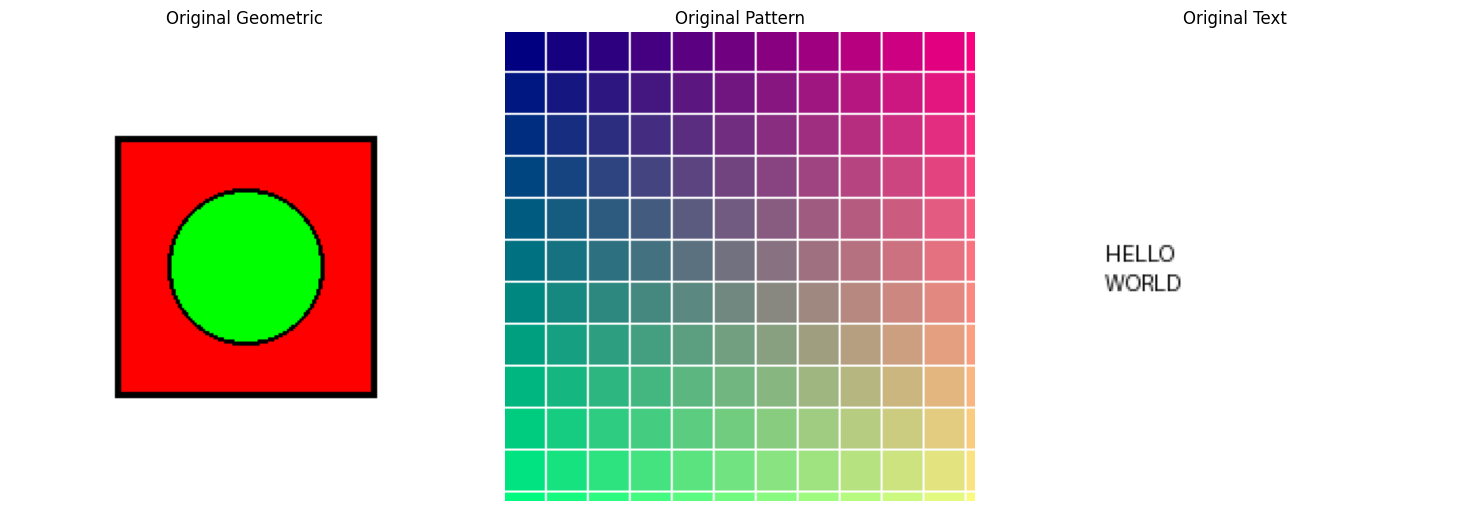

In [2]:
def create_sample_images():
    """Create sample images for augmentation demonstration"""
    images = []

    # Create a simple geometric image
    img1 = Image.new("RGB", (224, 224), color=(255, 255, 255))
    draw = ImageDraw.Draw(img1)
    draw.rectangle([50, 50, 174, 174], fill=(255, 0, 0), outline=(0, 0, 0), width=3)
    draw.ellipse([75, 75, 149, 149], fill=(0, 255, 0), outline=(0, 0, 0), width=2)
    images.append(("Geometric", img1))

    # Create a textured pattern
    img2 = Image.new("RGB", (224, 224), color=(255, 255, 255))
    draw = ImageDraw.Draw(img2)
    for i in range(0, 224, 20):
        for j in range(0, 224, 20):
            color = (int(i / 224 * 255), int(j / 224 * 255), 128)
            draw.rectangle([i, j, i + 18, j + 18], fill=color)
    images.append(("Pattern", img2))

    # Create an image with text (to show problematic augmentations)
    img3 = Image.new("RGB", (224, 224), color=(255, 255, 255))
    draw = ImageDraw.Draw(img3)
    try:
        # Try to use a default font
        font = ImageFont.load_default()
    except:
        font = None
    draw.text((50, 100), "HELLO\nWORLD", fill=(0, 0, 0), font=font)
    images.append(("Text", img3))

    return images


# Create sample images
sample_images = create_sample_images()

# Display the original images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (name, img) in enumerate(sample_images):
    axes[i].imshow(img)
    axes[i].set_title(f"Original {name}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()

## Basic Geometric Transformations

Let's start with the most common geometric transformations that preserve the semantic meaning of images.


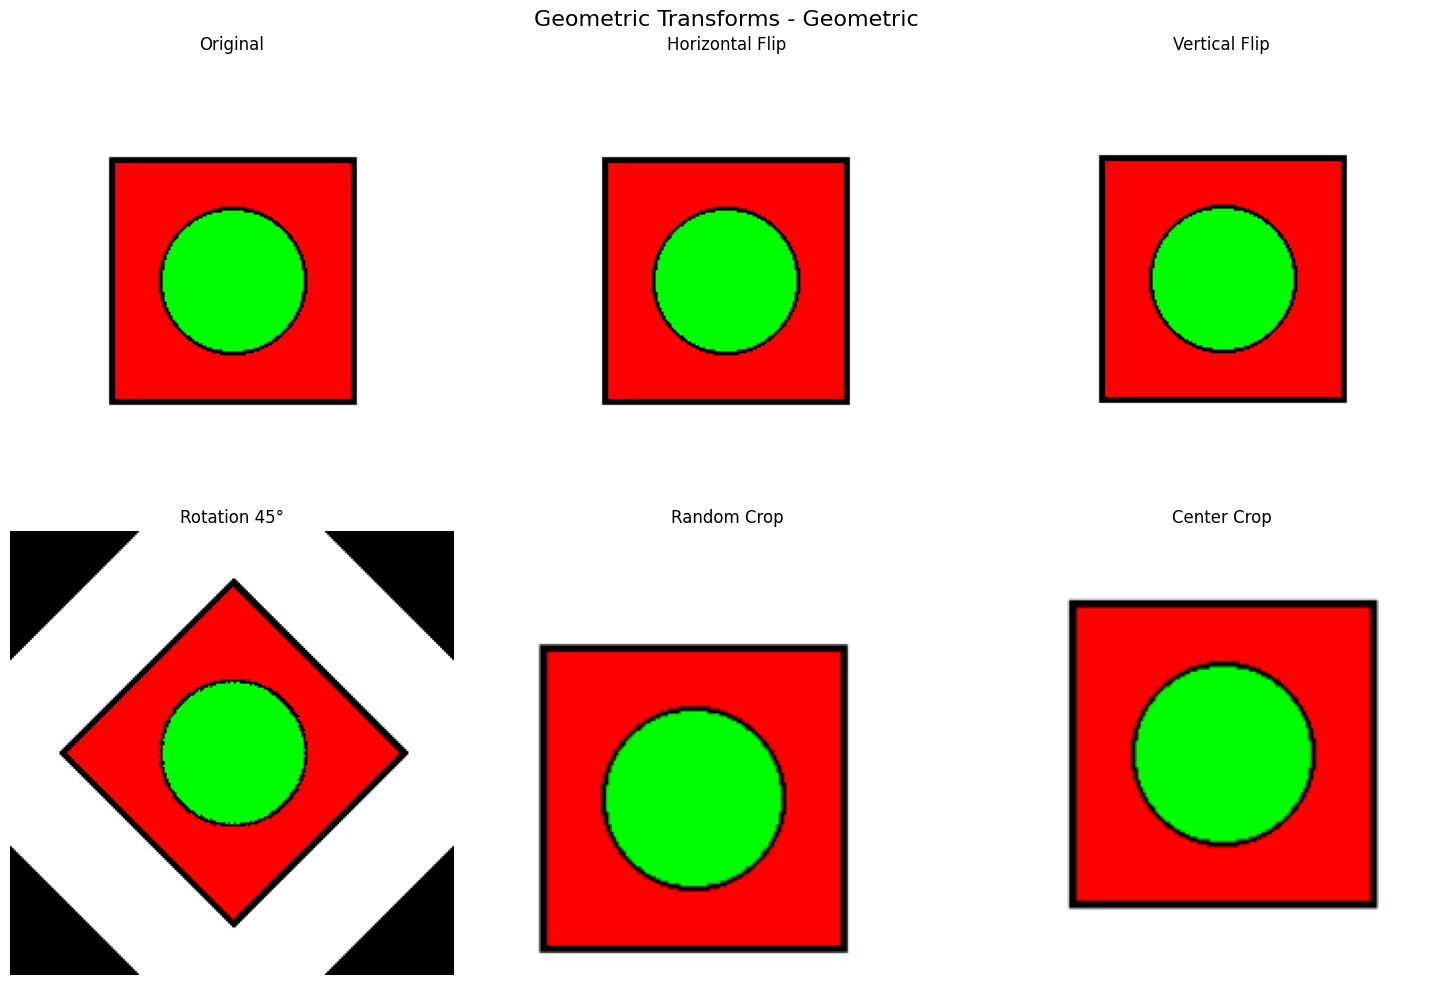

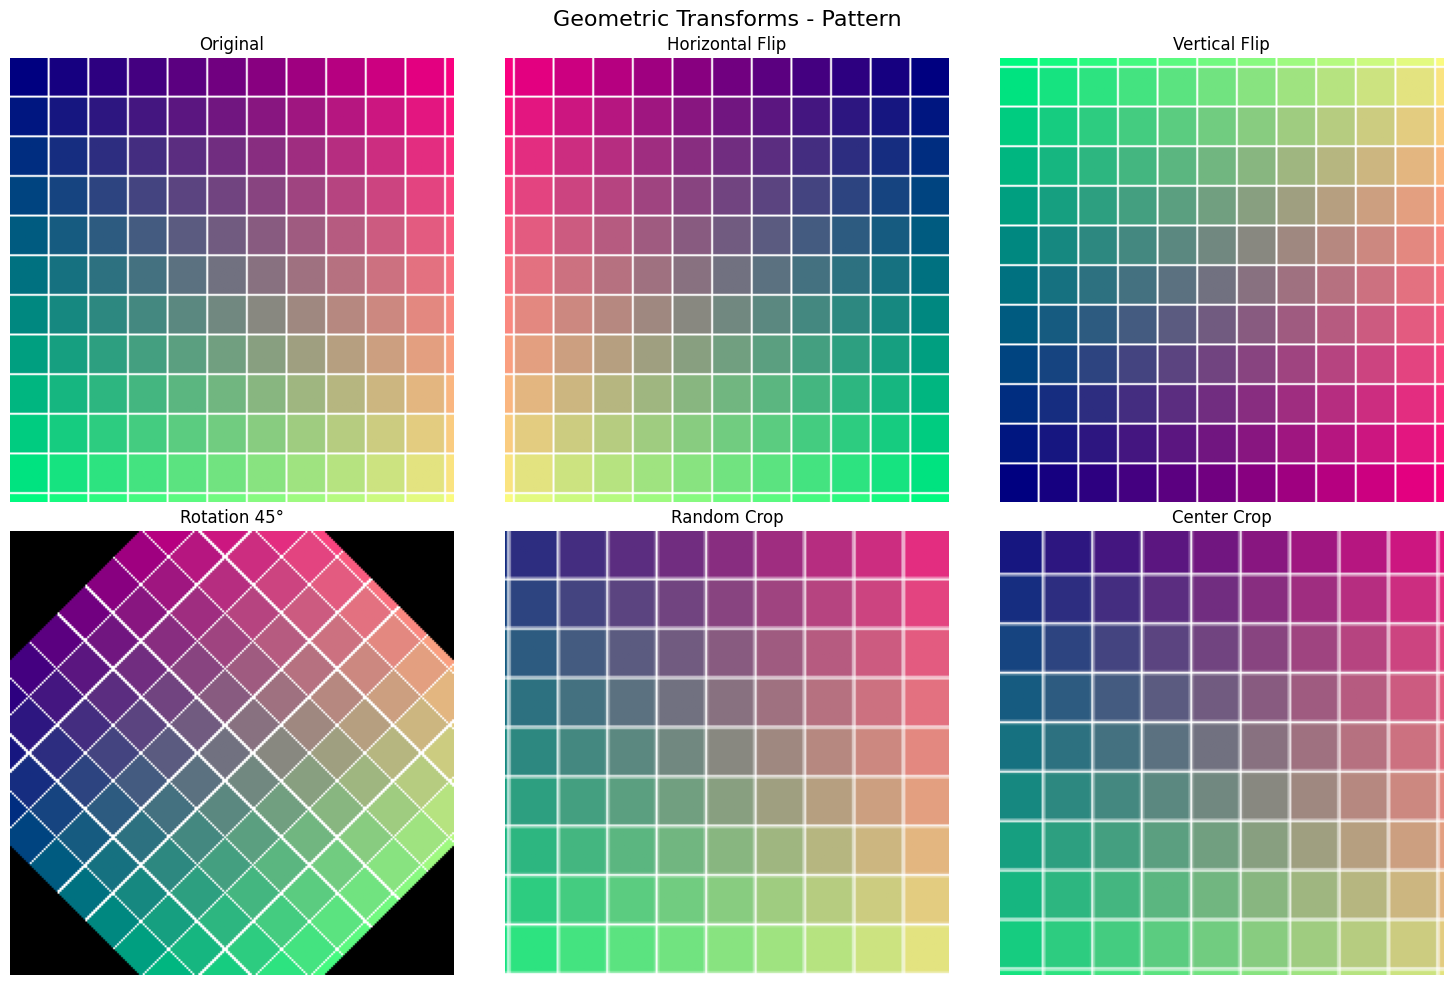

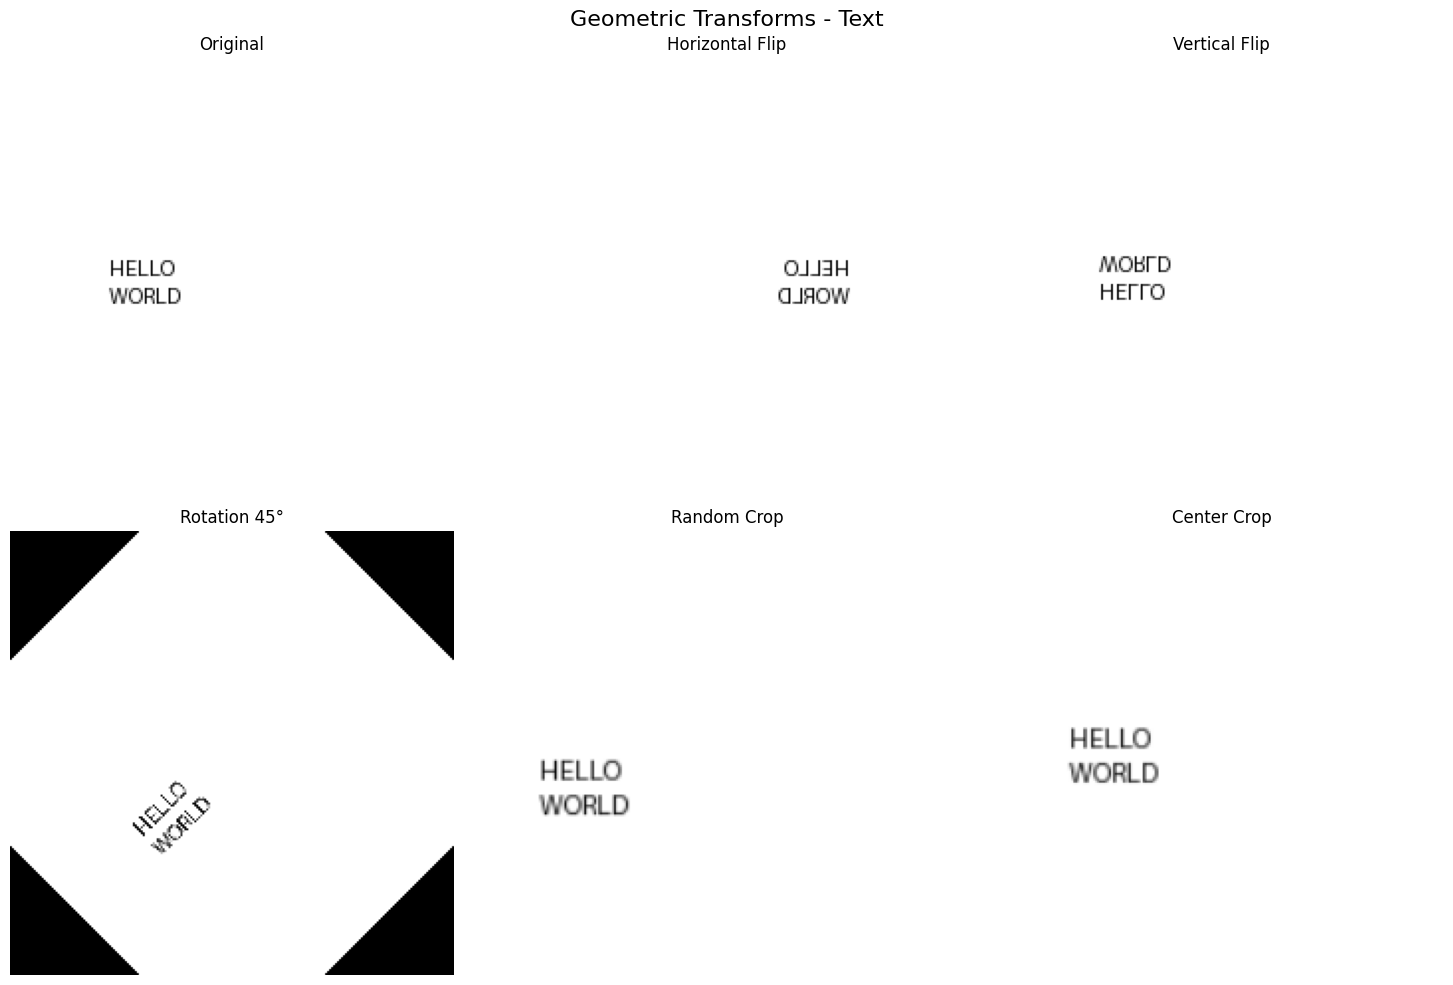

In [3]:
# Define basic geometric transforms
geometric_transforms = {
    "Original": transforms.Compose([transforms.ToTensor()]),
    "Horizontal Flip": transforms.Compose(
        [transforms.RandomHorizontalFlip(p=1.0), transforms.ToTensor()]
    ),
    "Vertical Flip": transforms.Compose(
        [transforms.RandomVerticalFlip(p=1.0), transforms.ToTensor()]
    ),
    "Rotation 45°": transforms.Compose(
        [transforms.RandomRotation(degrees=(45, 45)), transforms.ToTensor()]
    ),
    "Random Crop": transforms.Compose(
        [
            transforms.RandomCrop(size=(180, 180)),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ]
    ),
    "Center Crop": transforms.Compose(
        [
            transforms.CenterCrop(size=(180, 180)),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ]
    ),
}


def apply_transforms_and_visualize(image, transforms_dict, title="Transformations"):
    """Apply multiple transforms to an image and visualize results"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for i, (name, transform) in enumerate(transforms_dict.items()):
        if i >= 6:  # Only show first 6 transforms
            break

        # Apply transform
        if isinstance(image, Image.Image):
            transformed = transform(image)
        else:
            transformed = image

        # Convert tensor to displayable format
        if isinstance(transformed, torch.Tensor):
            if transformed.dim() == 3:  # CHW format
                img_display = transformed.permute(1, 2, 0)
            else:
                img_display = transformed
            img_display = torch.clamp(img_display, 0, 1)
        else:
            img_display = np.array(transformed) / 255.0

        axes[i].imshow(img_display)
        axes[i].set_title(name)
        axes[i].axis("off")

    # Hide unused subplots
    for i in range(len(transforms_dict), 6):
        axes[i].axis("off")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


# Apply geometric transformations to our sample images
for name, image in sample_images:
    apply_transforms_and_visualize(
        image, geometric_transforms, f"Geometric Transforms - {name}"
    )

## Photometric Transformations

Photometric transformations modify the pixel values to simulate different lighting conditions and camera settings.


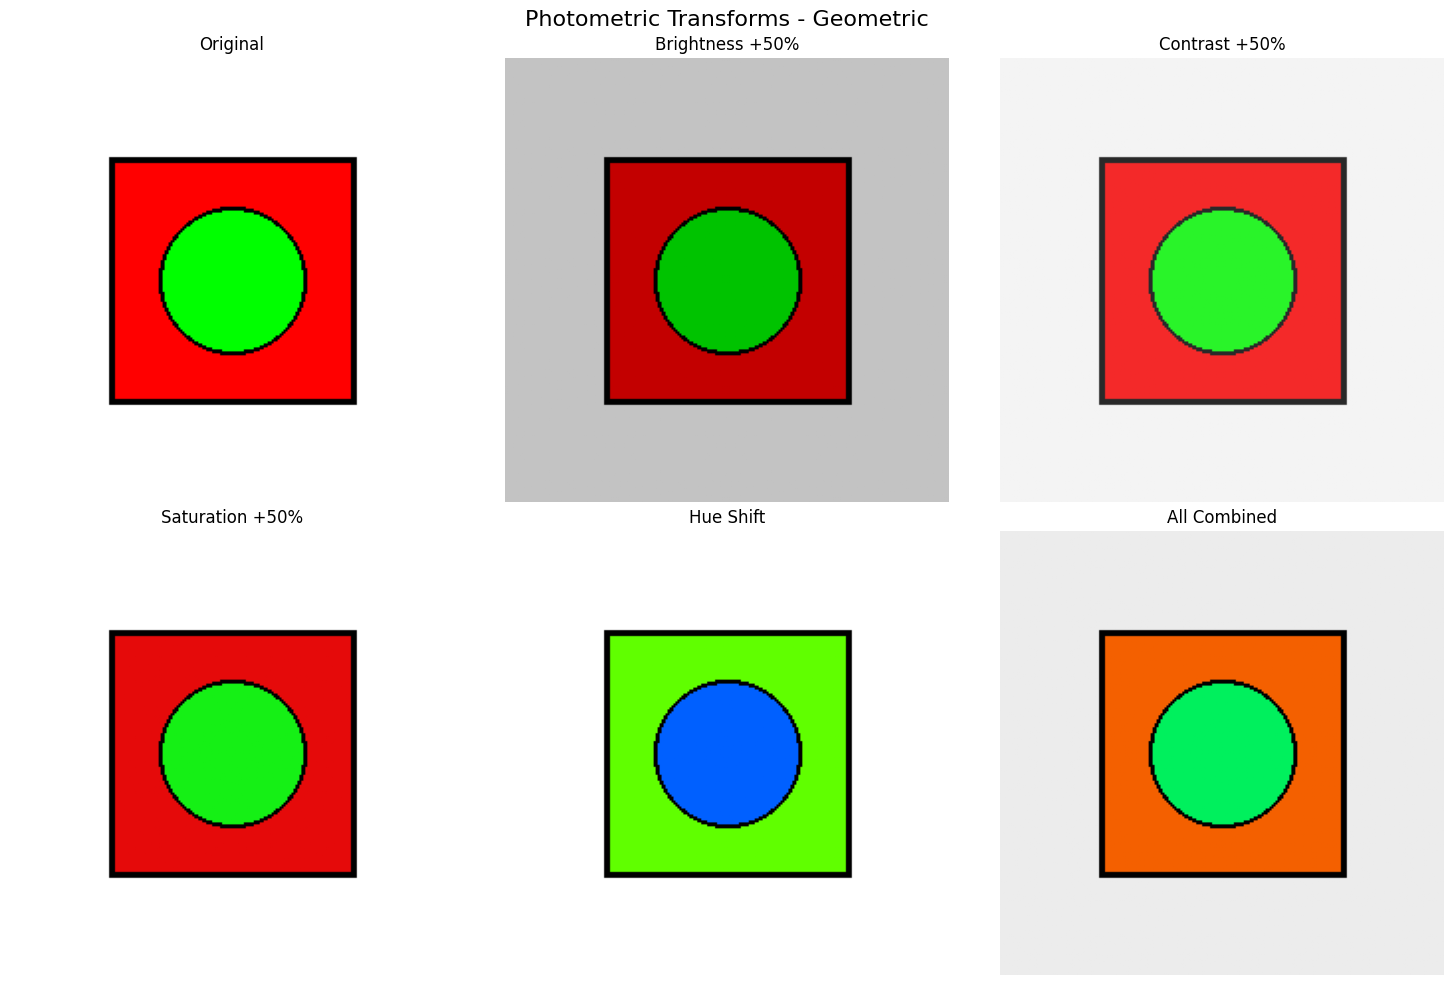

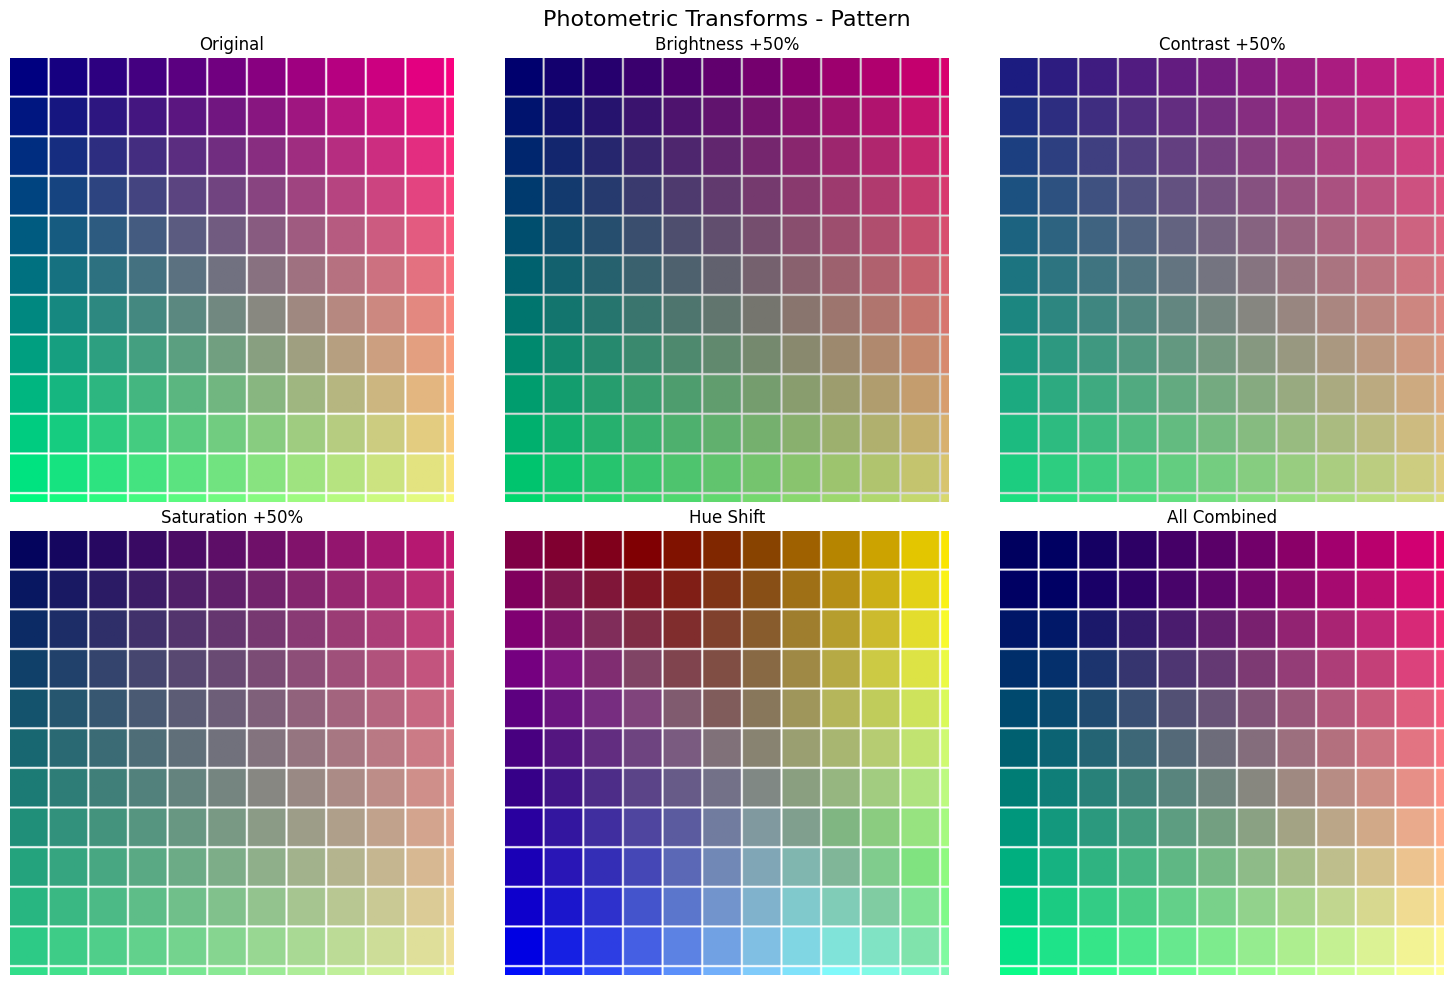

In [4]:
# Define photometric transforms
photometric_transforms = {
    "Original": transforms.Compose([transforms.ToTensor()]),
    "Brightness +50%": transforms.Compose(
        [transforms.ColorJitter(brightness=0.5), transforms.ToTensor()]
    ),
    "Contrast +50%": transforms.Compose(
        [transforms.ColorJitter(contrast=0.5), transforms.ToTensor()]
    ),
    "Saturation +50%": transforms.Compose(
        [transforms.ColorJitter(saturation=0.5), transforms.ToTensor()]
    ),
    "Hue Shift": transforms.Compose(
        [transforms.ColorJitter(hue=0.3), transforms.ToTensor()]
    ),
    "All Combined": transforms.Compose(
        [
            transforms.ColorJitter(
                brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1
            ),
            transforms.ToTensor(),
        ]
    ),
}

# Apply photometric transformations
for name, image in sample_images[:2]:  # Skip text image for this demo
    apply_transforms_and_visualize(
        image, photometric_transforms, f"Photometric Transforms - {name}"
    )

## Advanced Augmentation Techniques

Let's implement some advanced augmentation techniques that are commonly used in modern computer vision.


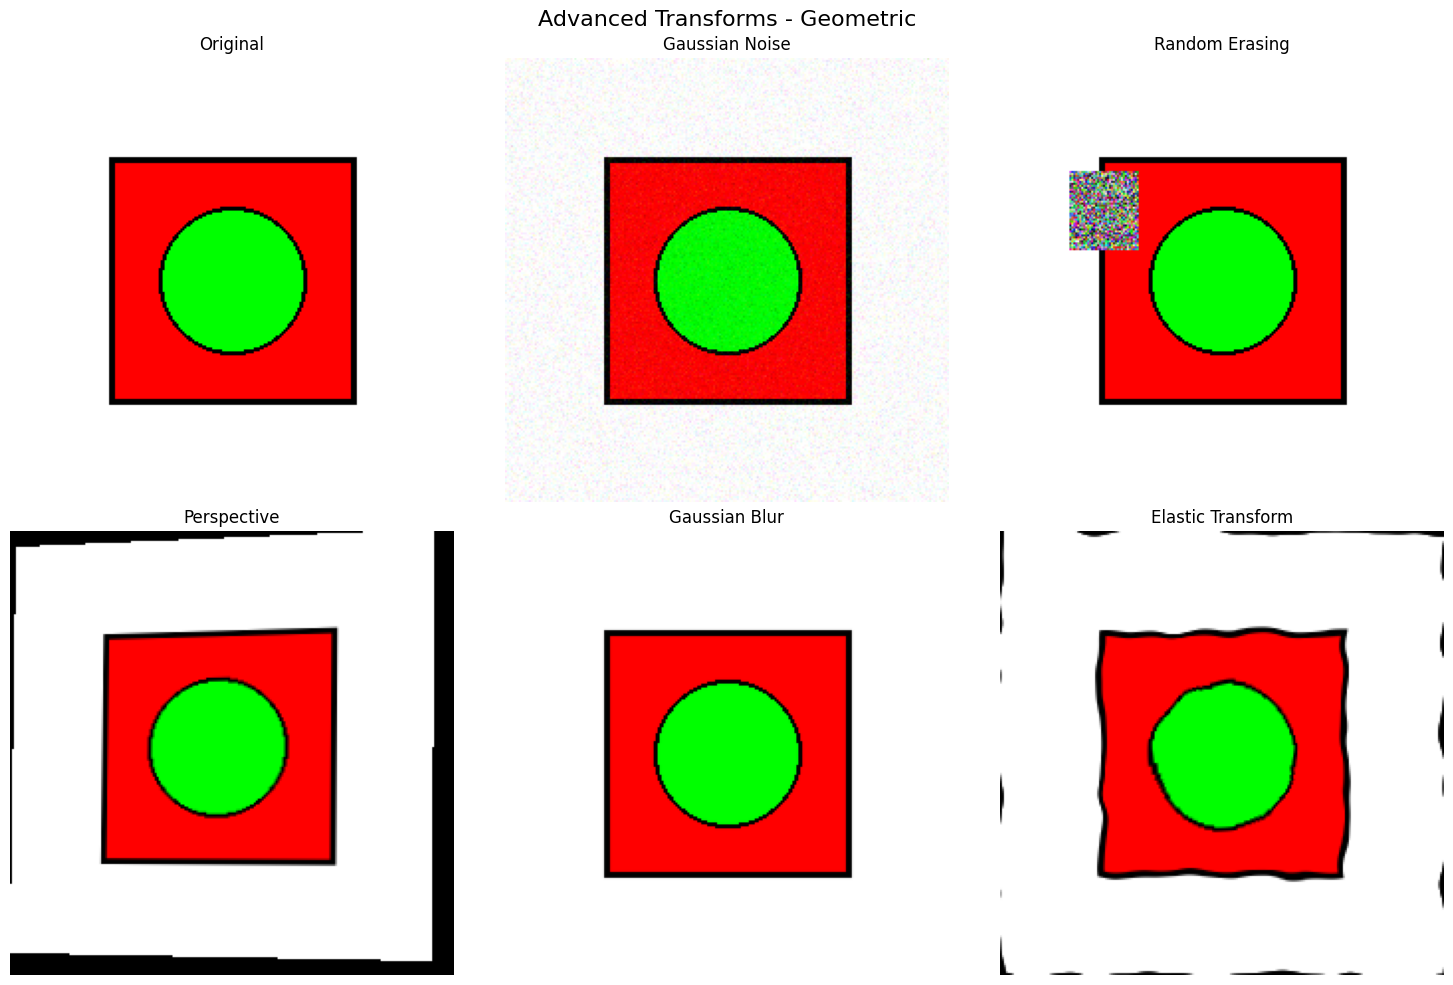

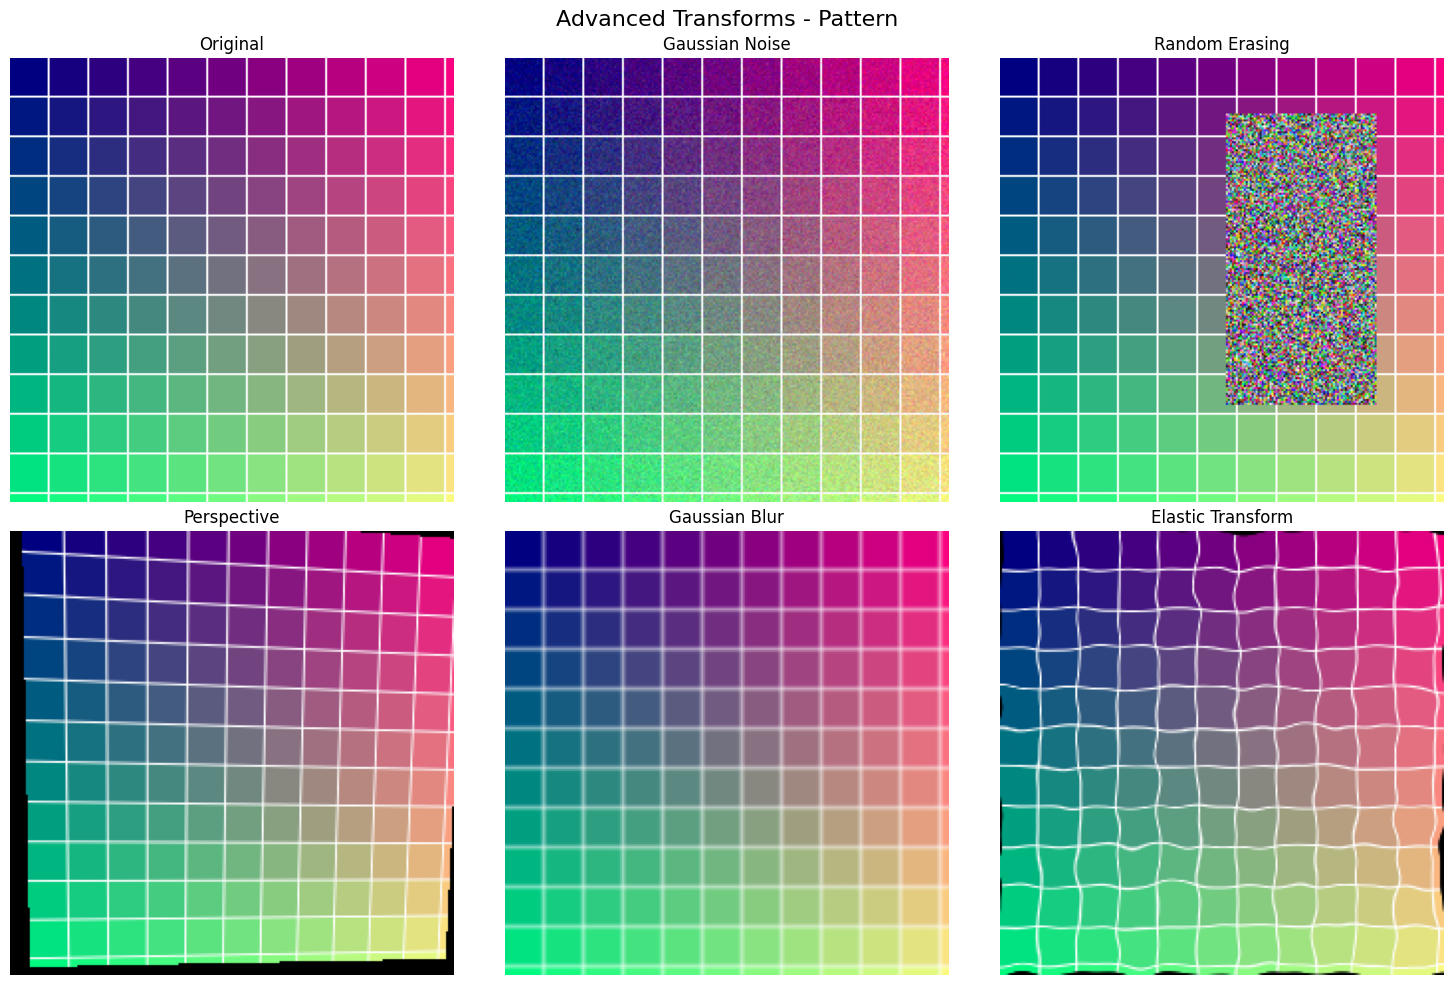

In [5]:
class GaussianNoise:
    """Add Gaussian noise to images"""

    def __init__(self, mean=0.0, std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn_like(tensor) * self.std + self.mean
        return torch.clamp(tensor + noise, 0.0, 1.0)


class RandomErasing:
    """Randomly erase a rectangular region in the image"""

    def __init__(self, p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)):
        self.p = p
        self.scale = scale
        self.ratio = ratio

    def __call__(self, tensor):
        if random.random() > self.p:
            return tensor

        _, h, w = tensor.shape
        area = h * w

        for _ in range(10):  # Try up to 10 times
            target_area = random.uniform(*self.scale) * area
            aspect_ratio = random.uniform(*self.ratio)

            h_erase = int(round(np.sqrt(target_area * aspect_ratio)))
            w_erase = int(round(np.sqrt(target_area / aspect_ratio)))

            if h_erase < h and w_erase < w:
                i = random.randint(0, h - h_erase)
                j = random.randint(0, w - w_erase)
                tensor[:, i : i + h_erase, j : j + w_erase] = torch.rand(
                    3, h_erase, w_erase
                )
                break

        return tensor


class RandomPerspective:
    """Apply random perspective transformation"""

    def __init__(self, distortion_scale=0.5, p=0.5):
        self.distortion_scale = distortion_scale
        self.p = p

    def __call__(self, img):
        if random.random() > self.p:
            return img

        width, height = img.size

        # Generate random perspective transformation
        startpoints = [[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]]
        endpoints = []

        for point in startpoints:
            x, y = point
            x += (
                random.uniform(-self.distortion_scale, self.distortion_scale)
                * width
                * 0.1
            )
            y += (
                random.uniform(-self.distortion_scale, self.distortion_scale)
                * height
                * 0.1
            )
            endpoints.append([int(x), int(y)])

        return TF.perspective(img, startpoints, endpoints)


# Define advanced transforms
advanced_transforms = {
    "Original": transforms.Compose([transforms.ToTensor()]),
    "Gaussian Noise": transforms.Compose(
        [transforms.ToTensor(), GaussianNoise(std=0.05)]
    ),
    "Random Erasing": transforms.Compose([transforms.ToTensor(), RandomErasing(p=1.0)]),
    "Perspective": transforms.Compose(
        [RandomPerspective(p=1.0), transforms.ToTensor()]
    ),
    "Gaussian Blur": transforms.Compose(
        [
            transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
            transforms.ToTensor(),
        ]
    ),
    "Elastic Transform": transforms.Compose(
        [transforms.ElasticTransform(alpha=50.0, sigma=5.0), transforms.ToTensor()]
    ),
}

# Apply advanced transformations
for name, image in sample_images[:2]:
    apply_transforms_and_visualize(
        image, advanced_transforms, f"Advanced Transforms - {name}"
    )

## Creating Comprehensive Augmentation Pipelines

Now let's create realistic augmentation pipelines that you would use in practice for different scenarios.


Training Pipeline (Aggressive Augmentation):


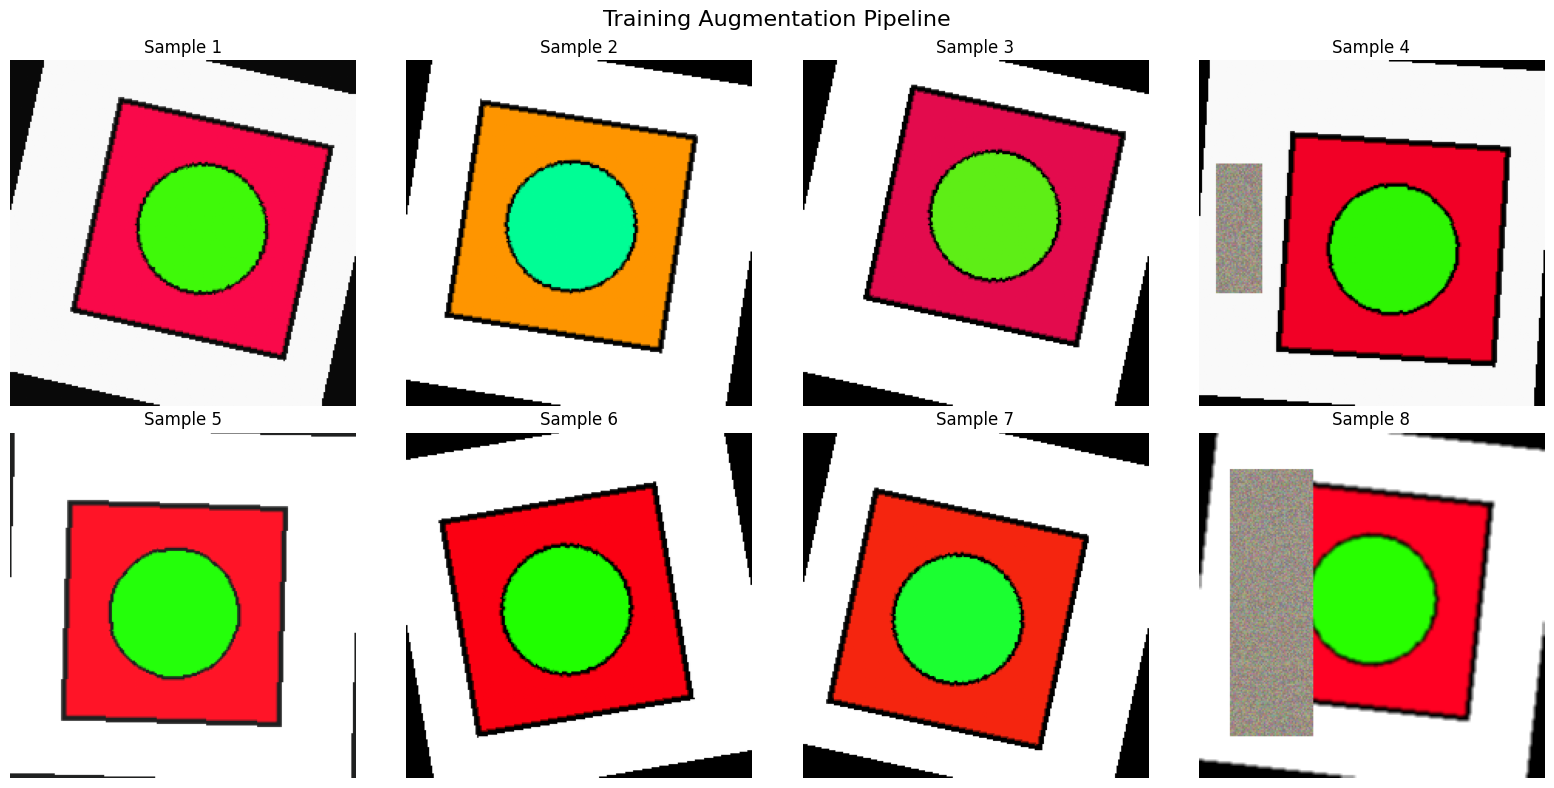


Validation Pipeline (Minimal Augmentation):


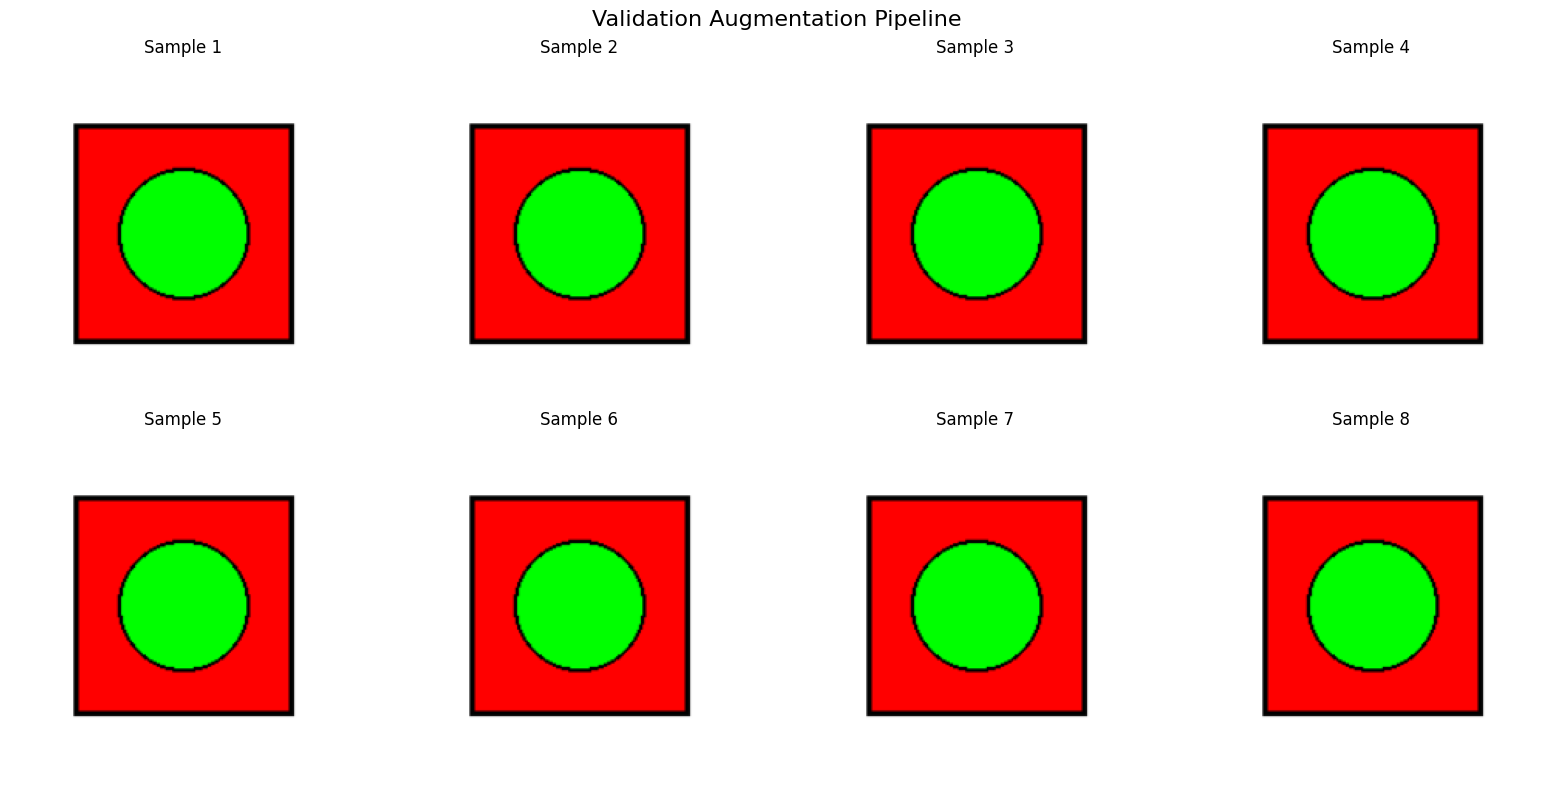

In [6]:
# Training augmentation pipeline - aggressive augmentation
train_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandomCrop((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomApply(
            [transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))], p=0.3
        ),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomApply([GaussianNoise(std=0.02)], p=0.2),
        transforms.RandomApply([RandomErasing(p=1.0)], p=0.3),
    ]
)

# Validation augmentation pipeline - minimal augmentation
val_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Test-time augmentation pipeline - multiple crops
tta_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.FiveCrop((224, 224)),  # Creates 5 crops: center + 4 corners
        transforms.Lambda(
            lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])
        ),
        transforms.Lambda(
            lambda crops: torch.stack(
                [
                    transforms.Normalize(
                        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                    )(crop)
                    for crop in crops
                ]
            )
        ),
    ]
)


def show_augmentation_pipeline(image, transform, title, num_samples=8):
    """Show multiple samples from an augmentation pipeline"""
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()

    for i in range(num_samples):
        # Apply transform
        if "FiveCrop" in str(transform):
            # Handle TTA transforms
            augmented = transform(image)
            # Show only the center crop
            sample = augmented[0]  # Center crop
        else:
            augmented = transform(image)
            sample = augmented

        # Convert to displayable format
        if isinstance(sample, torch.Tensor):
            if sample.dim() == 3:
                img_display = sample.permute(1, 2, 0)
                # Denormalize if normalized
                if sample.min() < 0:  # Likely normalized
                    img_display = img_display * torch.tensor(
                        [0.229, 0.224, 0.225]
                    ) + torch.tensor([0.485, 0.456, 0.406])
                img_display = torch.clamp(img_display, 0, 1)
            else:
                img_display = sample
        else:
            img_display = np.array(sample) / 255.0

        axes[i].imshow(img_display)
        axes[i].set_title(f"Sample {i+1}")
        axes[i].axis("off")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


# Show different augmentation strategies
geometric_image = sample_images[0][1]  # Use the geometric image

print("Training Pipeline (Aggressive Augmentation):")
show_augmentation_pipeline(
    geometric_image, train_transforms, "Training Augmentation Pipeline"
)

print("\nValidation Pipeline (Minimal Augmentation):")
show_augmentation_pipeline(
    geometric_image, val_transforms, "Validation Augmentation Pipeline"
)

## Test-Time Augmentation (TTA)

Test-time augmentation involves applying multiple augmentations during inference and averaging the predictions for better performance.


TTA samples shape: torch.Size([8, 3, 224, 224])


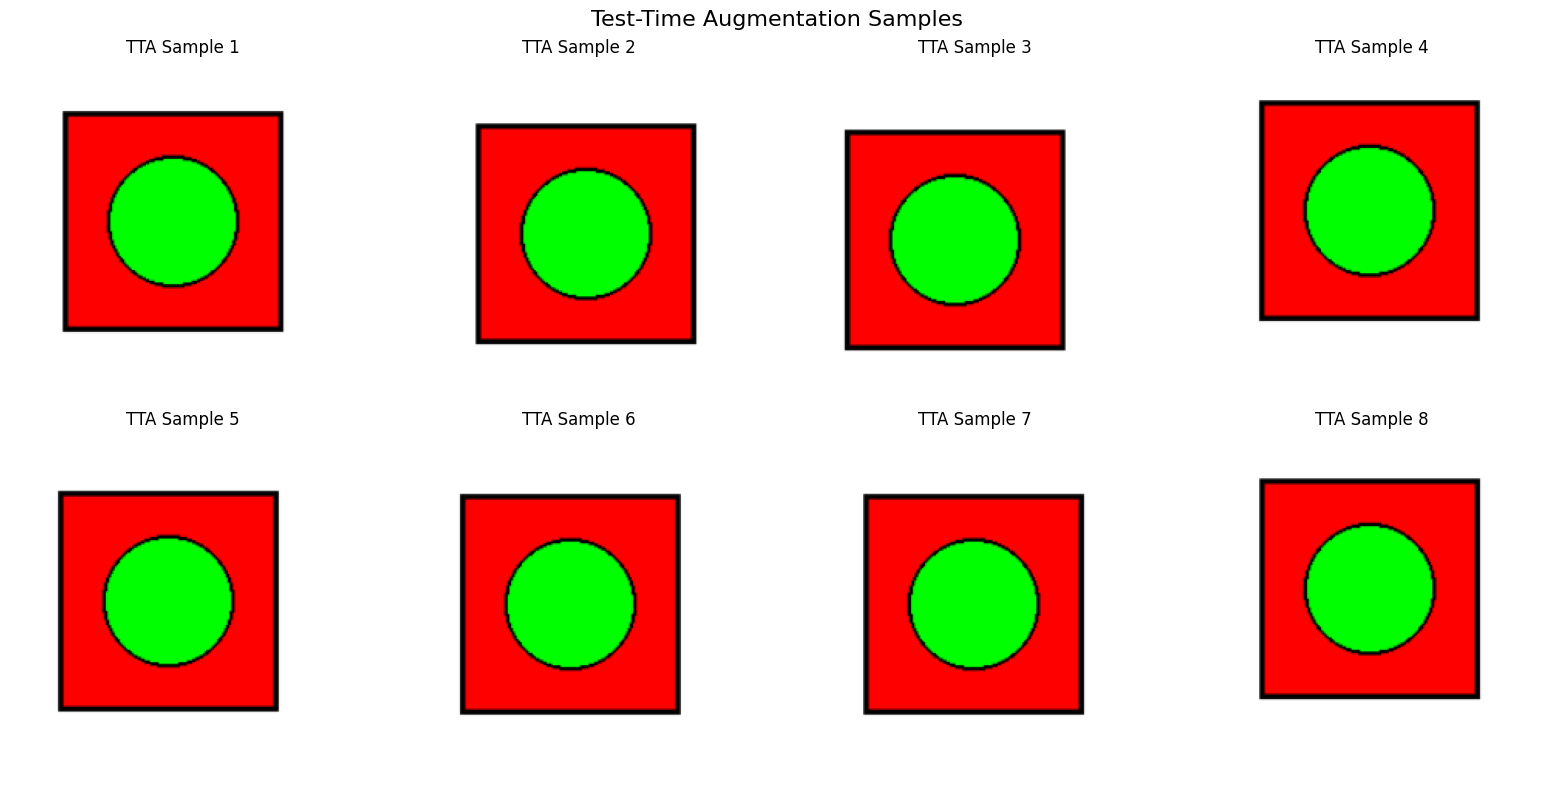

In [7]:
class TTADataset(Dataset):
    """Dataset wrapper for test-time augmentation"""

    def __init__(self, base_dataset, tta_transforms, num_tta=5):
        self.base_dataset = base_dataset
        self.tta_transforms = tta_transforms
        self.num_tta = num_tta

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        image, label = self.base_dataset[idx]

        # Apply TTA transforms
        tta_images = []
        for _ in range(self.num_tta):
            tta_image = self.tta_transforms(image)
            tta_images.append(tta_image)

        # Stack all TTA versions
        tta_batch = torch.stack(tta_images)
        return tta_batch, label


def demonstrate_tta():
    """Demonstrate test-time augmentation"""

    # Create a simple dataset with one image
    class SingleImageDataset(Dataset):
        def __init__(self, image):
            self.image = image

        def __len__(self):
            return 1

        def __getitem__(self, idx):
            return self.image, 0

    # TTA transforms (lighter than training)
    tta_transform = transforms.Compose(
        [
            transforms.Resize((256, 256)),
            transforms.RandomCrop((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    # Create datasets
    base_dataset = SingleImageDataset(geometric_image)
    tta_dataset = TTADataset(base_dataset, tta_transform, num_tta=8)

    # Get TTA samples
    tta_samples, label = tta_dataset[0]
    print(f"TTA samples shape: {tta_samples.shape}")

    # Visualize TTA samples
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()

    for i in range(8):
        sample = tta_samples[i]
        # Denormalize
        img_display = sample.permute(1, 2, 0)
        img_display = img_display * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor(
            [0.485, 0.456, 0.406]
        )
        img_display = torch.clamp(img_display, 0, 1)

        axes[i].imshow(img_display)
        axes[i].set_title(f"TTA Sample {i+1}")
        axes[i].axis("off")

    plt.suptitle("Test-Time Augmentation Samples", fontsize=16)
    plt.tight_layout()
    plt.show()


demonstrate_tta()

## MixUp and CutMix Augmentation

Advanced augmentation techniques that mix multiple images to create new training samples.


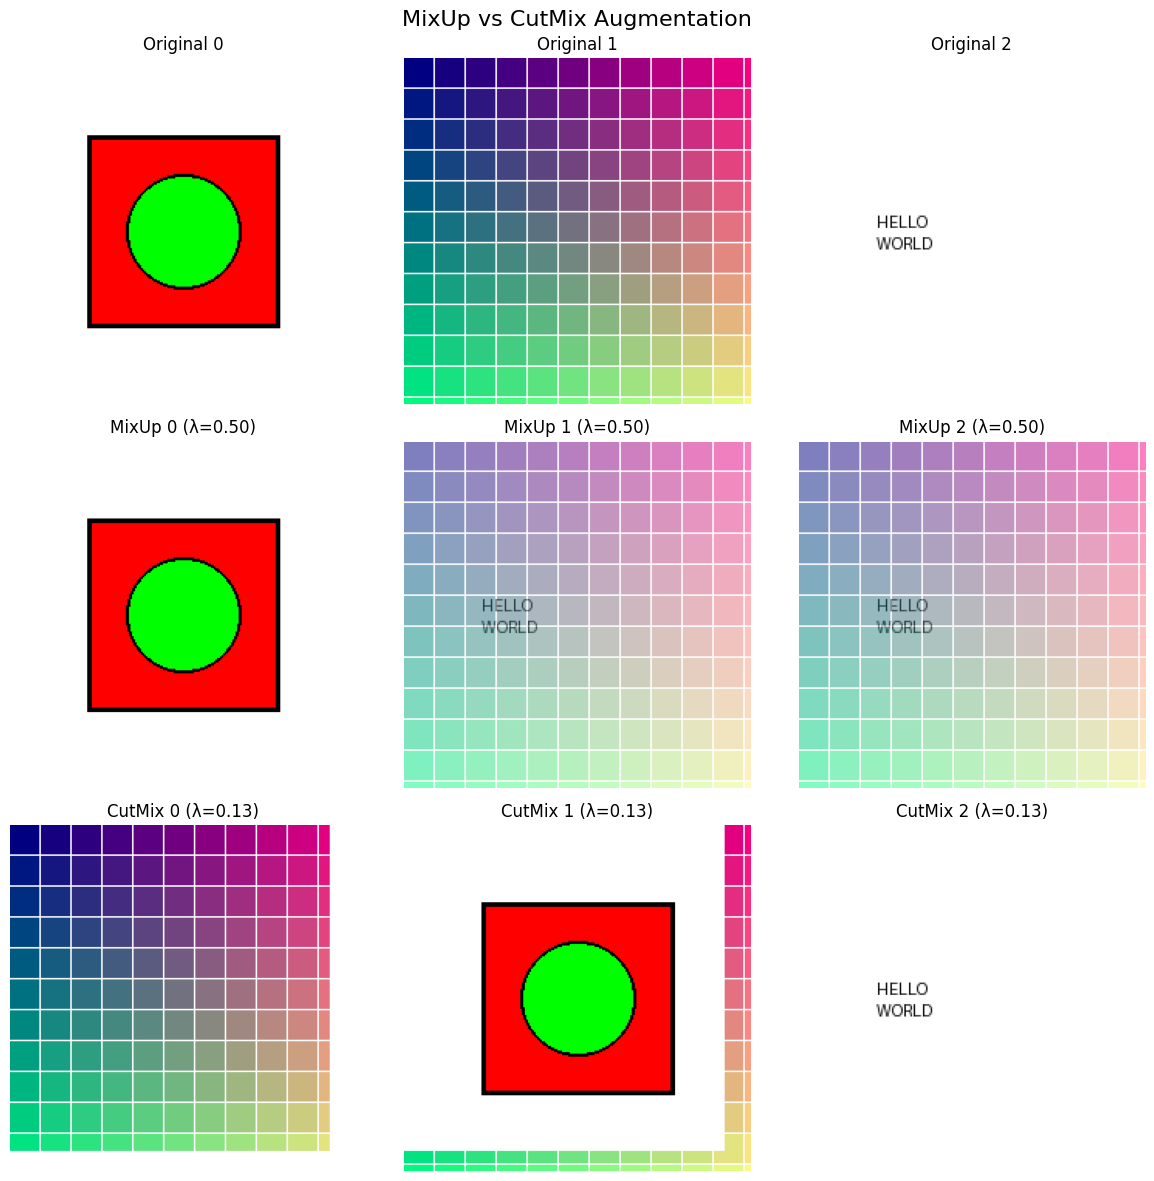

In [8]:
class MixUp:
    """
    MixUp augmentation: creates new samples by linearly combining pairs of images and labels
    """

    def __init__(self, alpha=1.0):
        self.alpha = alpha

    def __call__(self, batch_x, batch_y):
        if self.alpha > 0:
            lam = np.random.beta(self.alpha, self.alpha)
        else:
            lam = 1

        batch_size = batch_x.size(0)
        index = torch.randperm(batch_size)

        mixed_x = lam * batch_x + (1 - lam) * batch_x[index, :]
        y_a, y_b = batch_y, batch_y[index]

        return mixed_x, y_a, y_b, lam


class CutMix:
    """
    CutMix augmentation: combines parts of two images
    """

    def __init__(self, alpha=1.0):
        self.alpha = alpha

    def __call__(self, batch_x, batch_y):
        if self.alpha > 0:
            lam = np.random.beta(self.alpha, self.alpha)
        else:
            lam = 1

        batch_size = batch_x.size(0)
        index = torch.randperm(batch_size)

        # Generate random box
        W = batch_x.size(3)
        H = batch_x.size(2)
        cut_rat = np.sqrt(1.0 - lam)
        cut_w = int(W * cut_rat)
        cut_h = int(H * cut_rat)

        # Uniform sampling
        cx = np.random.randint(W)
        cy = np.random.randint(H)

        bbx1 = np.clip(cx - cut_w // 2, 0, W)
        bby1 = np.clip(cy - cut_h // 2, 0, H)
        bbx2 = np.clip(cx + cut_w // 2, 0, W)
        bby2 = np.clip(cy + cut_h // 2, 0, H)

        mixed_x = batch_x.clone()
        mixed_x[:, :, bby1:bby2, bbx1:bbx2] = batch_x[index, :, bby1:bby2, bbx1:bbx2]

        # Adjust lambda to exactly match pixel ratio
        lam = 1 - (
            (bbx2 - bbx1) * (bby2 - bby1) / (batch_x.size(-1) * batch_x.size(-2))
        )

        y_a, y_b = batch_y, batch_y[index]

        return mixed_x, y_a, y_b, lam


def demonstrate_mixup_cutmix():
    """Demonstrate MixUp and CutMix augmentations"""
    # Create a batch of sample images
    batch_images = []
    batch_labels = []

    # Convert sample images to tensors
    to_tensor = transforms.Compose(
        [transforms.Resize((224, 224)), transforms.ToTensor()]
    )

    for i, (name, img) in enumerate(sample_images):
        tensor_img = to_tensor(img)
        batch_images.append(tensor_img)
        batch_labels.append(i)

    batch_x = torch.stack(batch_images)
    batch_y = torch.tensor(batch_labels)

    # Apply MixUp
    mixup = MixUp(alpha=1.0)
    mixed_x_mixup, y_a, y_b, lam_mixup = mixup(batch_x, batch_y)

    # Apply CutMix
    cutmix = CutMix(alpha=1.0)
    mixed_x_cutmix, y_a, y_b, lam_cutmix = cutmix(batch_x, batch_y)

    # Visualize results
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))

    # Original images
    for i in range(3):
        axes[0, i].imshow(batch_x[i].permute(1, 2, 0))
        axes[0, i].set_title(f"Original {i}")
        axes[0, i].axis("off")

    # MixUp results
    for i in range(3):
        axes[1, i].imshow(mixed_x_mixup[i].permute(1, 2, 0))
        axes[1, i].set_title(f"MixUp {i} (λ={lam_mixup:.2f})")
        axes[1, i].axis("off")

    # CutMix results
    for i in range(3):
        axes[2, i].imshow(mixed_x_cutmix[i].permute(1, 2, 0))
        axes[2, i].set_title(f"CutMix {i} (λ={lam_cutmix:.2f})")
        axes[2, i].axis("off")

    plt.suptitle("MixUp vs CutMix Augmentation", fontsize=16)
    plt.tight_layout()
    plt.show()


demonstrate_mixup_cutmix()

## AutoAugment and RandAugment

Policy-based augmentation techniques that automatically find optimal augmentation strategies.


RandAugment Examples:


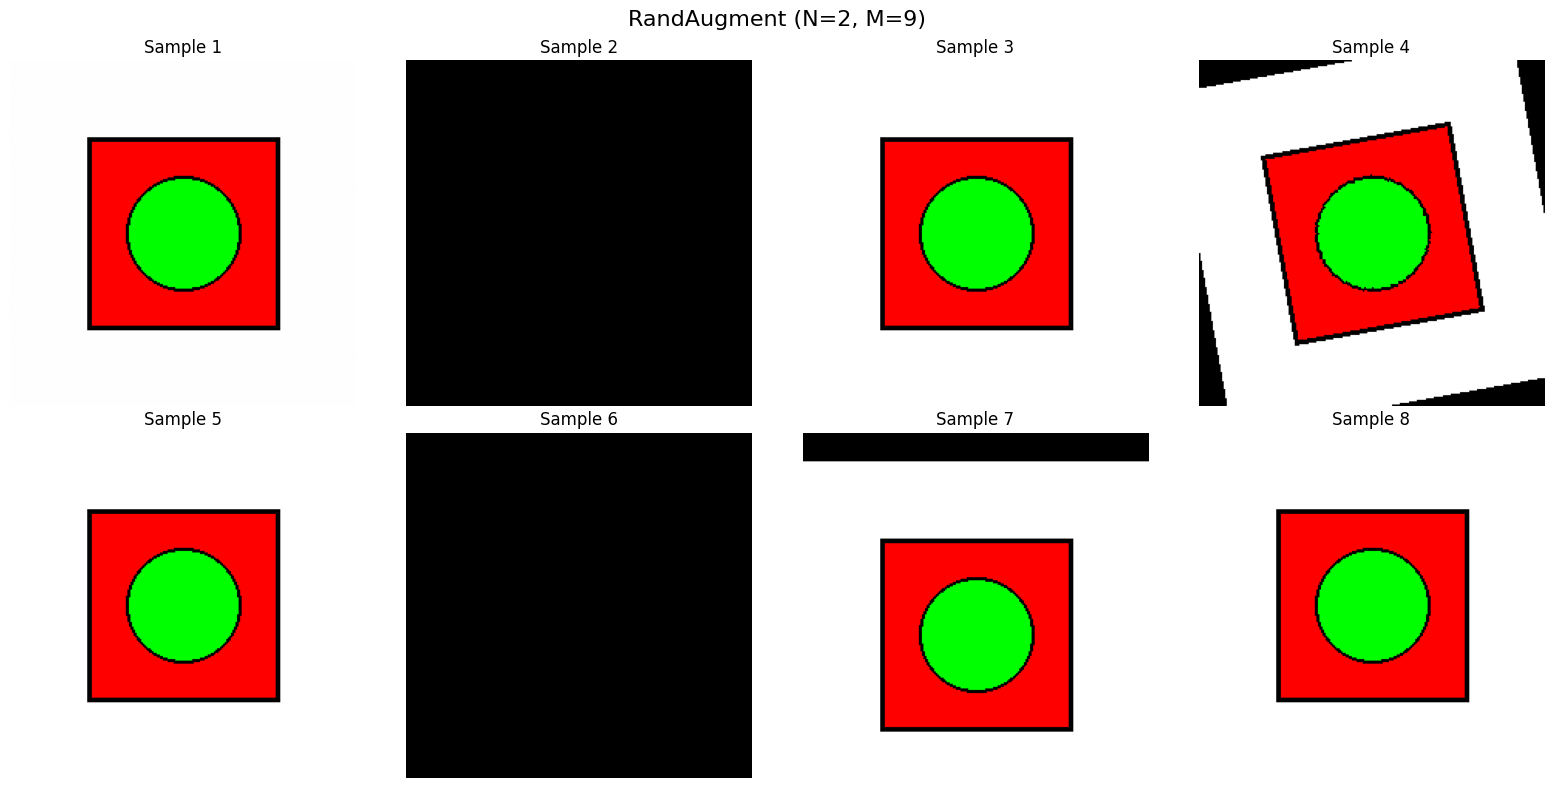

In [9]:
class RandAugment:
    """
    RandAugment implementation - randomly applies augmentation operations
    """

    def __init__(self, n=2, m=9):
        self.n = n  # Number of operations to apply
        self.m = m  # Magnitude of operations (0-30)

        # Available operations
        self.operations = [
            "AutoContrast",
            "Equalize",
            "Invert",
            "Rotate",
            "Posterize",
            "Solarize",
            "Color",
            "Contrast",
            "Brightness",
            "Sharpness",
            "ShearX",
            "ShearY",
            "TranslateX",
            "TranslateY",
        ]

    def __call__(self, img):
        # Randomly select n operations
        ops = random.sample(self.operations, self.n)

        for op in ops:
            # Apply operation with random magnitude
            magnitude = random.uniform(0, self.m)
            img = self._apply_operation(img, op, magnitude)

        return img

    def _apply_operation(self, img, operation, magnitude):
        """Apply a single operation to the image"""
        w, h = img.size

        if operation == "AutoContrast":
            return transforms.functional.autocontrast(img)
        elif operation == "Equalize":
            return transforms.functional.equalize(img)
        elif operation == "Invert":
            return transforms.functional.invert(img)
        elif operation == "Rotate":
            degrees = magnitude * 3  # Scale magnitude
            return transforms.functional.rotate(img, degrees)
        elif operation == "Posterize":
            bits = int(8 - magnitude / 30 * 4)  # 4-8 bits
            return transforms.functional.posterize(img, bits)
        elif operation == "Solarize":
            threshold = int(magnitude / 30 * 256)
            return transforms.functional.solarize(img, threshold)
        elif operation == "Color":
            factor = 1 + magnitude / 30 * 0.9
            return transforms.functional.adjust_saturation(img, factor)
        elif operation == "Contrast":
            factor = 1 + magnitude / 30 * 0.9
            return transforms.functional.adjust_contrast(img, factor)
        elif operation == "Brightness":
            factor = 1 + magnitude / 30 * 0.9
            return transforms.functional.adjust_brightness(img, factor)
        elif operation == "Sharpness":
            factor = 1 + magnitude / 30 * 0.9
            return transforms.functional.adjust_sharpness(img, factor)
        elif operation == "ShearX":
            shear = magnitude / 30 * 0.3
            return transforms.functional.affine(
                img, angle=0, translate=[0, 0], scale=1, shear=[shear, 0]
            )
        elif operation == "ShearY":
            shear = magnitude / 30 * 0.3
            return transforms.functional.affine(
                img, angle=0, translate=[0, 0], scale=1, shear=[0, shear]
            )
        elif operation == "TranslateX":
            translate = int(magnitude / 30 * w * 0.45)
            return transforms.functional.affine(
                img, angle=0, translate=[translate, 0], scale=1, shear=[0, 0]
            )
        elif operation == "TranslateY":
            translate = int(magnitude / 30 * h * 0.45)
            return transforms.functional.affine(
                img, angle=0, translate=[0, translate], scale=1, shear=[0, 0]
            )
        else:
            return img


# Define RandAugment pipeline
randaugment_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        RandAugment(n=2, m=9),
        transforms.ToTensor(),
    ]
)

# Demonstrate RandAugment
print("RandAugment Examples:")
show_augmentation_pipeline(
    geometric_image, randaugment_transform, "RandAugment (N=2, M=9)"
)

## Preprocessing Best Practices

Understanding proper preprocessing is crucial for model performance and reproducibility.


In [12]:
# Load a real dataset to demonstrate preprocessing
from torchvision import datasets

# Download CIFAR-10 for demonstration
cifar_dataset = datasets.CIFAR10(
    root="data", train=True, download=True, transform=transforms.ToTensor()
)


def analyze_dataset_statistics(dataset, num_samples=1000):
    """Analyze dataset statistics for normalization"""
    # Sample random images
    dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

    # Collect pixel values
    all_pixels = []
    sample_count = 0

    for images, _ in dataloader:
        all_pixels.append(images)
        sample_count += images.size(0)
        if sample_count >= num_samples:
            break

    # Concatenate all samples
    all_pixels = torch.cat(all_pixels, dim=0)[:num_samples]

    # Calculate statistics per channel
    mean = all_pixels.mean(dim=[0, 2, 3])
    std = all_pixels.std(dim=[0, 2, 3])

    print(f"Dataset Statistics (from {sample_count} samples):")
    print(f"Mean: R={mean[0]:.3f}, G={mean[1]:.3f}, B={mean[2]:.3f}")
    print(f"Std:  R={std[0]:.3f}, G={std[1]:.3f}, B={std[2]:.3f}")

    # Visualize distribution
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    colors = ["red", "green", "blue"]
    channel_names = ["Red", "Green", "Blue"]

    for i in range(3):
        channel_data = all_pixels[:, i, :, :].flatten()
        axes[i].hist(channel_data.numpy(), bins=50, alpha=0.7, color=colors[i])
        axes[i].axvline(
            mean[i], color="black", linestyle="--", label=f"Mean: {mean[i]:.3f}"
        )
        axes[i].set_title(f"{channel_names[i]} Channel Distribution")
        axes[i].set_xlabel("Pixel Value")
        axes[i].set_ylabel("Frequency")
        axes[i].legend()

    plt.tight_layout()
    plt.show()

    return mean.tolist(), std.tolist()


# Analyze CIFAR-10 statistics
cifar_mean, cifar_std = analyze_dataset_statistics(cifar_dataset)

  1%|          | 1.44M/170M [00:39<1:16:59, 36.6kB/s]



KeyboardInterrupt: 

In [ ]:
# Demonstrate the importance of proper normalization
def compare_normalization_effects():
    """Compare different normalization strategies"""

    # Get a sample batch
    sample_loader = DataLoader(cifar_dataset, batch_size=16, shuffle=True)
    sample_images, sample_labels = next(iter(sample_loader))

    # Different normalization strategies
    normalizations = {
        "No Normalization": lambda x: x,
        "Zero-One Scale": lambda x: x,  # Already in [0,1]
        "Mean Subtraction": lambda x: x - torch.tensor(cifar_mean).view(3, 1, 1),
        "Standard Normalization": lambda x: (x - torch.tensor(cifar_mean).view(3, 1, 1))
        / torch.tensor(cifar_std).view(3, 1, 1),
        "ImageNet Normalization": lambda x: (
            x - torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        )
        / torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1),
    }

    # Visualize normalization effects
    fig, axes = plt.subplots(len(normalizations), 4, figsize=(16, 20))

    for i, (name, norm_fn) in enumerate(normalizations.items()):
        for j in range(4):
            img = sample_images[j]
            normalized_img = norm_fn(img)

            # Convert to displayable format
            if name in [
                "Mean Subtraction",
                "Standard Normalization",
                "ImageNet Normalization",
            ]:
                # These can have negative values, need to handle carefully
                display_img = normalized_img.permute(1, 2, 0)
                # Normalize to [0,1] for display
                display_img = (display_img - display_img.min()) / (
                    display_img.max() - display_img.min()
                )
            else:
                display_img = normalized_img.permute(1, 2, 0)
                display_img = torch.clamp(display_img, 0, 1)

            axes[i, j].imshow(display_img)
            if j == 0:
                axes[i, j].set_ylabel(name, rotation=90, size=12)
            axes[i, j].axis("off")

            # Add statistics
            axes[i, j].set_title(
                f"Mean: {normalized_img.mean():.2f}\nStd: {normalized_img.std():.2f}",
                fontsize=8,
            )

    plt.suptitle("Effects of Different Normalization Strategies", fontsize=16)
    plt.tight_layout()
    plt.show()


compare_normalization_effects()

## Performance Considerations

Let's examine the performance impact of different augmentation strategies.


In [ ]:
def benchmark_augmentation_performance():
    """Benchmark different augmentation pipelines"""

    # Create test dataset
    test_images = [sample_images[0][1]] * 100  # Replicate for testing

    # Different augmentation pipelines
    pipelines = {
        "No Augmentation": transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
            ]
        ),
        "Light Augmentation": transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
            ]
        ),
        "Medium Augmentation": transforms.Compose(
            [
                transforms.Resize((256, 256)),
                transforms.RandomCrop((224, 224)),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(0.1, 0.1, 0.1, 0.05),
                transforms.ToTensor(),
            ]
        ),
        "Heavy Augmentation": transforms.Compose(
            [
                transforms.Resize((256, 256)),
                transforms.RandomCrop((224, 224)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),
                transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
                transforms.RandomApply([transforms.GaussianBlur(3)], p=0.3),
                transforms.ToTensor(),
                RandomErasing(p=0.3),
            ]
        ),
    }

    # Benchmark each pipeline
    results = {}

    for name, pipeline in pipelines.items():
        start_time = time.time()

        for img in test_images:
            _ = pipeline(img)

        elapsed_time = time.time() - start_time
        results[name] = elapsed_time
        print(
            f"{name}: {elapsed_time:.3f}s ({elapsed_time/len(test_images)*1000:.1f}ms per image)"
        )

    # Visualize performance
    plt.figure(figsize=(10, 6))
    names = list(results.keys())
    times = list(results.values())

    bars = plt.bar(names, times, color=["green", "yellow", "orange", "red"])
    plt.ylabel("Time (seconds)")
    plt.title("Augmentation Pipeline Performance Comparison")
    plt.xticks(rotation=45)

    # Add value labels on bars
    for bar, time_val in zip(bars, times):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.01,
            f"{time_val:.3f}s",
            ha="center",
            va="bottom",
        )

    plt.tight_layout()
    plt.show()

    return results


# Run performance benchmark
print("Benchmarking augmentation performance...")
perf_results = benchmark_augmentation_performance()

## Domain-Specific Considerations

Different domains require different augmentation strategies. Let's explore guidelines for various applications.


In [ ]:
def create_domain_specific_pipelines():
    """Create augmentation pipelines for different domains"""

    # Natural Images (ImageNet-style)
    natural_images_train = transforms.Compose(
        [
            transforms.Resize((256, 256)),
            transforms.RandomCrop((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(
                brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1
            ),
            transforms.RandomApply(
                [transforms.GaussianBlur(3, sigma=(0.1, 2.0))], p=0.3
            ),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    # Medical Images (more conservative)
    medical_images_train = transforms.Compose(
        [
            transforms.Resize((256, 256)),
            transforms.RandomCrop((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),  # Only if anatomically valid
            transforms.RandomRotation(degrees=5),  # Small rotations only
            transforms.ColorJitter(
                brightness=0.1, contrast=0.1
            ),  # Minimal color changes
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5]),  # Assuming grayscale
        ]
    )

    # Satellite Images
    satellite_images_train = transforms.Compose(
        [
            transforms.Resize((256, 256)),
            transforms.RandomCrop((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),  # Valid for satellite imagery
            transforms.RandomRotation(degrees=90),  # 90-degree rotations valid
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    # Document Images (OCR)
    document_images_train = transforms.Compose(
        [
            transforms.Resize((256, 256)),
            transforms.RandomCrop((224, 224)),
            # NO horizontal/vertical flips (would make text unreadable)
            transforms.RandomRotation(degrees=2),  # Very small rotations only
            transforms.ColorJitter(
                brightness=0.1, contrast=0.2
            ),  # Simulate scanning conditions
            transforms.RandomApply(
                [transforms.GaussianBlur(1)], p=0.1
            ),  # Simulate blur
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    return {
        "Natural Images": natural_images_train,
        "Medical Images": medical_images_train,
        "Satellite Images": satellite_images_train,
        "Document Images": document_images_train,
    }


# Create domain-specific pipelines
domain_pipelines = create_domain_specific_pipelines()

# Demonstrate on our sample images
print("Domain-Specific Augmentation Examples:")
for domain_name, pipeline in domain_pipelines.items():
    print(f"\n{domain_name}:")
    # Show 4 samples for each domain
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    for i in range(4):
        augmented = pipeline(geometric_image)

        # Convert to displayable format
        img_display = augmented.permute(1, 2, 0)
        # Denormalize
        if domain_name == "Medical Images":
            img_display = img_display * 0.5 + 0.5
        else:
            img_display = img_display * torch.tensor(
                [0.229, 0.224, 0.225]
            ) + torch.tensor([0.485, 0.456, 0.406])
        img_display = torch.clamp(img_display, 0, 1)

        axes[i].imshow(img_display)
        axes[i].set_title(f"Sample {i+1}")
        axes[i].axis("off")

    plt.suptitle(f"{domain_name} Augmentation Strategy", fontsize=14)
    plt.tight_layout()
    plt.show()

## Best Practices and Guidelines

### 1. When to Use Different Augmentations

| Augmentation Type   | Good For                | Avoid When                                      |
| ------------------- | ----------------------- | ----------------------------------------------- |
| **Horizontal Flip** | Natural images, objects | Text, medical scans with orientation importance |
| **Rotation**        | Objects, natural scenes | Text, maps with fixed orientation               |
| **Color Jitter**    | Natural images          | Medical images, scientific data                 |
| **Crop/Resize**     | Most image types        | When spatial relationships are critical         |
| **Blur**            | Robustness to quality   | High-resolution requirements                    |
| **Noise**           | Robustness training     | Clean data requirements                         |

### 2. Progressive Augmentation Strategy

Start conservative and gradually increase augmentation intensity:


In [ ]:
def create_progressive_augmentation(stage="beginner"):
    """Create augmentation pipelines for different training stages"""

    base_transforms = [
        transforms.Resize((256, 256)),
        transforms.RandomCrop((224, 224)),
    ]

    if stage == "beginner":
        # Conservative augmentation
        stage_transforms = [
            transforms.RandomHorizontalFlip(p=0.5),
        ]
    elif stage == "intermediate":
        # Moderate augmentation
        stage_transforms = [
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=10),
            transforms.ColorJitter(brightness=0.1, contrast=0.1),
        ]
    elif stage == "advanced":
        # Aggressive augmentation
        stage_transforms = [
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(
                brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1
            ),
            transforms.RandomApply([transforms.GaussianBlur(3)], p=0.3),
        ]
    else:
        stage_transforms = []

    final_transforms = [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]

    return transforms.Compose(base_transforms + stage_transforms + final_transforms)


# Demonstrate progressive augmentation
stages = ["beginner", "intermediate", "advanced"]
for stage in stages:
    pipeline = create_progressive_augmentation(stage)
    print(f"\n{stage.title()} Stage Augmentation:")
    show_augmentation_pipeline(
        geometric_image, pipeline, f"{stage.title()} Augmentation", num_samples=4
    )

### 3. Monitoring Augmentation Effects

It's important to monitor how augmentation affects your model's performance.


In [ ]:
def analyze_augmentation_impact():
    """Analyze how different augmentation strategies might affect training"""

    # Simulate different scenarios
    scenarios = {
        "No Augmentation": {
            "training_accuracy": 0.95,
            "validation_accuracy": 0.82,
            "test_accuracy": 0.80,
            "overfitting_risk": "High",
        },
        "Light Augmentation": {
            "training_accuracy": 0.92,
            "validation_accuracy": 0.88,
            "test_accuracy": 0.87,
            "overfitting_risk": "Medium",
        },
        "Moderate Augmentation": {
            "training_accuracy": 0.89,
            "validation_accuracy": 0.87,
            "test_accuracy": 0.86,
            "overfitting_risk": "Low",
        },
        "Heavy Augmentation": {
            "training_accuracy": 0.84,
            "validation_accuracy": 0.84,
            "test_accuracy": 0.83,
            "overfitting_risk": "Very Low",
        },
        "Excessive Augmentation": {
            "training_accuracy": 0.78,
            "validation_accuracy": 0.76,
            "test_accuracy": 0.75,
            "overfitting_risk": "Very Low (Underfitting)",
        },
    }

    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Accuracy comparison
    names = list(scenarios.keys())
    train_acc = [scenarios[name]["training_accuracy"] for name in names]
    val_acc = [scenarios[name]["validation_accuracy"] for name in names]
    test_acc = [scenarios[name]["test_accuracy"] for name in names]

    x = np.arange(len(names))
    width = 0.25

    ax1.bar(x - width, train_acc, width, label="Training", alpha=0.8)
    ax1.bar(x, val_acc, width, label="Validation", alpha=0.8)
    ax1.bar(x + width, test_acc, width, label="Test", alpha=0.8)

    ax1.set_xlabel("Augmentation Strategy")
    ax1.set_ylabel("Accuracy")
    ax1.set_title("Accuracy vs Augmentation Strategy")
    ax1.set_xticks(x)
    ax1.set_xticklabels(names, rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Overfitting analysis
    overfitting_gap = [train_acc[i] - val_acc[i] for i in range(len(names))]
    colors = [
        "red" if gap > 0.05 else "orange" if gap > 0.02 else "green"
        for gap in overfitting_gap
    ]

    ax2.bar(names, overfitting_gap, color=colors, alpha=0.7)
    ax2.set_xlabel("Augmentation Strategy")
    ax2.set_ylabel("Overfitting Gap (Train - Val)")
    ax2.set_title("Overfitting vs Augmentation Strategy")
    ax2.set_xticklabels(names, rotation=45)
    ax2.grid(True, alpha=0.3)

    # Add reference line
    ax2.axhline(
        y=0.05,
        color="red",
        linestyle="--",
        alpha=0.7,
        label="High Overfitting Threshold",
    )
    ax2.axhline(
        y=0.02,
        color="orange",
        linestyle="--",
        alpha=0.7,
        label="Medium Overfitting Threshold",
    )
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # Print recommendations
    print("Augmentation Strategy Recommendations:")
    for name, data in scenarios.items():
        gap = data["training_accuracy"] - data["validation_accuracy"]
        print(f"\n{name}:")
        print(f"  - Overfitting Gap: {gap:.3f}")
        print(f"  - Risk Level: {data['overfitting_risk']}")
        if gap > 0.05:
            print("  - ⚠️  Consider more augmentation")
        elif gap < 0.01 and data["test_accuracy"] < 0.85:
            print("  - ⚠️  Might be under-augmented or underfitting")
        else:
            print("  - ✅ Good balance")


analyze_augmentation_impact()

## Summary and Best Practices

### Key Takeaways:

1. **Start Conservative**: Begin with basic augmentations and gradually increase complexity
2. **Domain Awareness**: Choose augmentations appropriate for your specific domain
3. **Monitor Performance**: Track both training and validation metrics to detect overfitting/underfitting
4. **Test-Time Augmentation**: Use TTA for improved inference performance when computational budget allows
5. **Performance vs. Accuracy**: Balance augmentation complexity with computational requirements

### Recommended Augmentation Pipeline:

```python
# Standard computer vision pipeline
train_transforms = transforms.Compose([
    # Resize and crop
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),

    # Geometric augmentations
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),

    # Photometric augmentations
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

    # Advanced augmentations (optional)
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.3),

    # Normalize
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

    # Tensor augmentations
    transforms.RandomApply([RandomErasing(p=1.0)], p=0.3),
])
```

### When to Use Advanced Techniques:

- **MixUp/CutMix**: When you have limited data and want to improve generalization
- **AutoAugment/RandAugment**: When you have computational resources for policy search
- **Test-Time Augmentation**: For critical applications where accuracy is more important than speed
- **Progressive Augmentation**: When training very deep networks or when starting from scratch

### Common Mistakes to Avoid:

1. **Over-augmentation**: Too much augmentation can hurt performance
2. **Domain Mismatches**: Using inappropriate augmentations for your data type
3. **Inconsistent Preprocessing**: Different normalization between train/val/test
4. **Ignoring Performance Impact**: Not considering computational costs
5. **Not Validating**: Not checking that augmentations preserve labels

Remember: **Good augmentation is about finding the right balance between data diversity and computational efficiency while preserving the semantic content of your images!**
